
# SqueezeNets - Deep Learning na categoria Peso-Pena.




A maioria das pesquisas/competições de Deep Learning focam somente na acurácia, mas esse pensamento é insustentável quando confrontado com uma situação de deploy da solução, principalmente quando pensamos em escalabilidade ou portabilidade.
Problemas comums no sistema de produção, o tamanho dos modelos e a latência de inferência são os grandes culpados no deploy de maioria das ConvNets populares (VGG, ResNet, Inception, etc.) ocupando facilmente várias centenas de MB com seus parâmetros e apresentando latência considerável na inferência. 

# Pesos-Pesados para comparação
<img src="Imagens/CNNs.png">

<h2 style='padding: 10px'>VGG16 x AlexNet</h2><table class='table table-striped'> <thead> <tr> <th>VGG16</th> <th>AlexNet</th></tr> </thead> <tbody> <tr> <td>138M Parâmetros ~ 528MB</td> <td>60M Parâmetros ~ 285MB</td>  </tr> <tr> <td>16 Camadas </td> <td>8 Camadas</td> </tr> <tr> <td>Filtros 3x3</td> <td>Filtros 5x5 e 3x3</td> </tr> <tr> <td>top-5 accuracy de 92.3 % na ImageNet.</td> <td>top-5 accuracy de 80.6% na ImageNet.</td>  </tr> </tbody> </table>




# Mas não se aborreça, pequeno padawan. As Redes Peso-Pena como SqueezeNets e MobileNets vieram para sanar este problema !

<table><tr><td><img src="Imagens/motivacao.png"></td><td><img src="Imagens/motivacao2.png"></td></tr></table>



# Qual a Mágica ?

Na verdade, é um fato conhecido que as ConvNets tem muito mais conexões do que precisam para fazer seu trabalho. 
No paper “Deep Compression” de Han et al. o autor prova que o tamanho da VGG - 16 pode ser reduzido por um fator 49 somente pela poda de conexões sem importância, mantendo a acurácia da rede. 

# SqueezeNets vs "ConvNets"

Principais pontos de diferença com uma ConvNet:
- Maioria dos kernels reduzidos de 3x3 para 1x1 (Redução de 9x nos parâmetros)
- Canais de entrada nos filtros 3x3 restantes são alterados para diminuir parâmetros 
  -  i.e.  NParam = (input channels) * (number of filters) * (3*3).
- Ausência de camadas FC 
- Output gerada com o uso de Avg. Pooling
- Introdução do módulo <font color=red>__FIRE__</font> **( Squeeze + Expand )**

# O quê ? Filtro 1x1 ?


Embora a convolução de 1 x 1 seja uma técnica de "agrupamento de features", há mais do que apenas a soma de "features" em vários canais/"mapas de features" de uma determinada camada. A convolução de 1x1 atua como uma transformação dependente de coordenadas no espaço de filtro.

É importante notar aqui que esta transformação é estritamente linear, mas na maior parte da aplicação da convolução 1x1, ela é sucedida por uma camada de ativação não linear como ReLU. Essa transformação é aprendida através da descida gradiente (estocástica). Mas uma distinção importante é que ela sofre com menos adaptação devido ao tamanho menor do kernel (1x1).

A convolução 1x1 foi criada para gerar uma rede mais profunda sem simplesmente empilhar mais camadas. Substituindo alguns filtros por uma camada menor com uma mistura de convoluções 1x1 e 3x3. De certa forma, essa abordagem pode ser vista como "net widening" em vez do clássico "net deepening". 

Na arquitetura GoogLeNet, por exemplo, a convolução de 1x1 é usada para três propósitos:

- Para tornar a rede mais profunda, adicionando um “módulo de widening”
- Para reduzir as dimensões dentro deste "módulo de widening".
- Para adicionar mais não-linearidade por ter ReLU imediatamente após cada convolução de 1x1.

<img src="Imagens/conv1x1.png">

# O módulo __FIRE__

<img src="Imagens/fogo.gif">


Um módulo <font color=red>__FIRE__</font>  é composto por: 
- Uma camada de convolução de compressão (que tem apenas filtros 1x1), alimentando em uma camada de expansão que tem uma mistura de convolução 1x1 e 3x3 filtros;
- Em um módulo Fire, **s1x1** é o número de filtros na camada de "squeeze" (totalmente 1x1), **e1x1** é o número de filtros 1x1 na camada de expansão e **e3x3** é o número de filtros 3x3 na camada de expansão. 
- Normalmente definimos s1x1 como menor que (e1x1 + e3x3), de modo que a camada "squeeze" ajuda a limitar o número de canais de entrada para os filtros 3x3, reduzindo os parâmetros.

<img src="Imagens/fire.png">

# A Arquitetura Completa 


<img src="Imagens/squeezefull.png">

***

**Tá bom, chega de teoria, hora de botar a mão na massa !**

Começamos importando todos os pacotes que iremos usar :

In [1]:
import tensorflow as tf
import os, argparse
import time
import numpy as np
import h5py
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.python.framework import graph_util

/home/wesley/Projects-I2A2/deep_learning/venv/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


Depois criamos a pasta para guardar o modelo treinado e o dataset do MNIST :

In [2]:
!mkdir models
!mkdir MNIST

Agora criamos as variáveis *"placeholders"* do tensorflow para guardar os dados de entrada/saída e a taxa de passagem da camada dropout. Além disso, criamos as variáveis de controle para guardar o número de classes e o limite do gradiente.

In [3]:
x = tf.placeholder(tf.float32,(None,28*28),name='X')
y = tf.placeholder(tf.float32,(None,10),name='Y')
keep_prob = tf.placeholder(tf.float32,name='dropout')
classCount = 10
grad_limit = 50

Por fim, criamos uma estrutura para guardar a arquitetura, inserimos nesta a entrada **x** e definimos a quantidade de filtros convolucionais e "squeezes" da camada FIRE.

In [4]:
activations = []
x_image = tf.reshape(x,(-1,28,28,1))
activations.append(x_image)
filters = [16,16,32,32,48,48,64,64]
squeezes= [4,4,8, 8, 12, 12, 16, 16]

Agora o **core** do nosso código, vamos definir as funções que realizam a compressão e expansão dos dados, além de uma funçãozinha para percorrer o grafo da arquitetura e contar os parâmetros. (*getSize()*)

In [5]:
def squeeze(inputs,squeezeTo):
    with tf.name_scope('squeeze'):
        inputSize = inputs.get_shape().as_list()[3]
        w = tf.Variable(tf.truncated_normal([1,1,inputSize,squeezeTo]))
        h = tf.nn.relu(tf.nn.conv2d(inputs,w,[1,1,1,1],'SAME'))        
    return h

def expand(inputs,expandTo):
    with tf.name_scope('expand'):
        squeezeTo = inputs.get_shape().as_list()[3]
        w = tf.Variable(tf.truncated_normal([1,1,squeezeTo,expandTo]))
        h1x1 = tf.nn.relu(tf.nn.conv2d(inputs,w,[1,1,1,1],'SAME'))
        w = tf.Variable(tf.truncated_normal([3,3,squeezeTo,expandTo]))
        h3x3 = tf.nn.relu(tf.nn.conv2d(inputs,w,[1,1,1,1],'SAME'))
        h = tf.concat([h1x1,h3x3],3)
    return h
def fire(inputs,squeezeTo,expandTo):
    h = squeeze(inputs,squeezeTo)
    h = expand(h,expandTo)
    h = tf.clip_by_norm(h,grad_limit)
    activations.append(h)


def getSize():
    total_parameters = 0
    for variable in tf.trainable_variables():
        shape = variable.get_shape()
        variable_parametes = 1
        for dim in shape:
            variable_parametes *= dim.value 
        total_parameters += variable_parametes
    return total_parameters

Definimos agora a arquitetura, combinando o módulo FIRE com camadas convolucionais e maxpooling para diminuir os parâmetros.


In [6]:

with tf.name_scope('conv1'):
    w = tf.Variable(tf.truncated_normal([3,3,1,64]))
    h = tf.nn.relu(tf.nn.conv2d(activations[-1],w,[1,2,2,1],'SAME'))
    activations.append(h)

with tf.name_scope('maxpool1'):
    h = tf.nn.max_pool(activations[-1],[1,3,3,1],[1,2,2,1],'SAME')
    activations.append(h)

for i in range(0,2):
    with tf.name_scope('fire'+str(i+2)):
        fire(activations[-1],squeezes[i],filters[i])

with tf.name_scope('maxpool2'):
    h = tf.nn.max_pool(activations[-1],[1,3,3,1],[1,2,2,1],'SAME')
    activations.append(h)

for i in range(2,4):
    with tf.name_scope('fire'+str(i+2)):
        fire(activations[-1],squeezes[i],filters[i])

with tf.name_scope('maxpool3'):
    h = tf.nn.max_pool(activations[-1],[1,3,3,1],[1,2,2,1],'SAME')
    activations.append(h)

for i in range(4,7):
    with tf.name_scope('fire'+str(i+2)):
        fire(activations[-1],squeezes[i],filters[i])

with tf.name_scope('dropout'):
    h = tf.nn.dropout(activations[-1],keep_prob)
    activations.append(h)

with tf.name_scope('conv10'):
    input_shape = activations[-1].get_shape().as_list()[3]
    w = tf.Variable(tf.truncated_normal([1,1,input_shape,classCount]))
    h = tf.nn.relu(tf.nn.conv2d(activations[-1],w,[1,1,1,1],'SAME'))
    activations.append(h)

with tf.name_scope('avgpool'):
    input_shape = activations[-1].get_shape().as_list()[2]
    h = tf.nn.avg_pool(activations[-1],[1,input_shape,input_shape,1],[1,1,1,1],'VALID')
    h = tf.squeeze(h,[1,2])
    activations.append(h)

Com a arquitetura decidida, definimos a saída da rede usando um Softmax e, por fim, a nossa função de perda e otimizador.

As variáveis *correct_prediction* e *accuracy* são variáveis de controle que podem ser acessadas pelo tensorboard ou requisitadas pela sessão.

In [7]:
y_conv = tf.nn.softmax(activations[-1],name='Output')
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=activations[-1], labels=y)
train_step = tf.train.AdamOptimizer(1e-2).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32),name='Accuracy')

tf.summary.scalar('accuracy',accuracy)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



<tf.Tensor 'accuracy:0' shape=() dtype=string>

Vamos treinar agora, salvando sempre quando atingimos a melhor acurácia de validação !

In [8]:
sess = tf.InteractiveSession()

merged = tf.summary.merge_all()
summaryWriter = tf.summary.FileWriter('./Tensorboard',sess.graph)

sess.run(tf.global_variables_initializer())
mnist = input_data.read_data_sets('MNIST', one_hot=True)
saver = tf.train.Saver()
start_time = time.time()
print('Started')
print('Números de parâmetros : %d '%getSize())
run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
run_metadata = tf.RunMetadata()
best_acc = 0
for i in range(1001):
    batch = mnist.train.next_batch(150)
    if i%50 == 0:
        summary, train_accuracy = sess.run([merged, accuracy],
                                    feed_dict={x: batch[0], y: batch[1],keep_prob: 1},
                                    options=run_options,
                                    run_metadata=run_metadata)
        summaryWriter.add_run_metadata(run_metadata, 'step%03d' % i)
        summaryWriter.add_summary(summary, i)
        valid_accuracy = sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels,keep_prob: 1})
        
        print("Epoch %d, training accuracy  %2.2f%%, validation accuracy %2.2f%%"%(i, 100*train_accuracy,
                                                100*valid_accuracy))
        if(best_acc < valid_accuracy):
            best_acc = valid_accuracy
            save_path = saver.save(sess, "models/model.ckpt")

    train_step.run(feed_dict={x: batch[0], y: batch[1],keep_prob:.5})

print("Training Finished ! Best Accuracy : %f"%best_acc)
save_path = saver.save(sess, "models/model.ckpt")
print("Model saved in file: %s" % save_path)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models

Agora que treinamos nossa squeezenet e salvamos seu modelo, como usar isso denovo ?

# Inferência usando um modelo pré-treinado.

Para usar o modelo, primeiro vamos executar uma função originalmente nativa do tensorflow, mas modificada para a nossa squeeze, que "poda" o grafo do modelo de seus nós de treinamento, congelando sua forma e gerando um modelo final de tamanho reduzido!

In [10]:
def freeze_graph(model_folder,output_node):
    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_folder)
    input_checkpoint = checkpoint.model_checkpoint_path

    # We precise the file fullname of our freezed graph
    absolute_model_folder = '/'.join(input_checkpoint.split('/')[:-1])
    output_graph ='frozen_model.pb'

    # Before exporting our graph, we need to precise what is our output node
    # This is how TF decides what part of the Graph he has to keep and what part it can dump
    # NOTE: this variable is plural, because you can have multiple output nodes
    output_node_names = output_node

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We import the meta graph and retrieve a Saver
    saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

    # We retrieve the protobuf graph definition
    graph = tf.get_default_graph()
    input_graph_def = graph.as_graph_def()

    # We start a session and restore the graph weights
    with tf.Session() as sess:
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        output_graph_def = graph_util.convert_variables_to_constants(
            sess,  # The session is used to retrieve the weights
            input_graph_def,  # The graph_def is used to retrieve the nodes
            output_node_names.split(",")  # The output node names are used to select the usefull nodes
        )

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, 'wb') as f:
            f.write(output_graph_def.SerializeToString())
        print('%d ops in the final graph.' % len(output_graph_def.node))

In [11]:
freeze_graph("models","Accuracy")

INFO:tensorflow:Restoring parameters from models/model.ckpt
INFO:tensorflow:Froze 23 variables.
Converted 23 variables to const ops.
206 ops in the final graph.


Pronto, agora você tem um modelo treinado e congelado da Squeeze para o MNIST !

Vamos testar essa belezinha, começamos com uma função para importar o grafo do arquivo congelado.


In [12]:
def load_graph(frozen_graph_filename):
    """Load a (frozen) Tensorflow model into memory."""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(frozen_graph_filename, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

Importamos o grafo congelado e recuperamos os tensores pelos nomes que definimos na primeira etapa.

In [13]:
mnist = input_data.read_data_sets('MNIST', one_hot=True)
graph = load_graph('frozen_model.pb')
input = graph.get_tensor_by_name('X:0')
input_labels = graph.get_tensor_by_name('Y:0')
output = graph.get_tensor_by_name('Output:0')
dropout = graph.get_tensor_by_name('dropout:0')
accuracy = graph.get_tensor_by_name('Accuracy:0')

Extracting MNIST/train-images-idx3-ubyte.gz
Extracting MNIST/train-labels-idx1-ubyte.gz
Extracting MNIST/t10k-images-idx3-ubyte.gz
Extracting MNIST/t10k-labels-idx1-ubyte.gz


Hora de fazer uma inferência ! Repare no tempo e confira a acurácia com sua acurácia de treino.

In [14]:
sess = tf.Session(graph=graph)
start = time.time()
res = sess.run(output, feed_dict={input: mnist.test.images[5].reshape(1,784),dropout: 1})
end = time.time()
print("Primeira inferência : Time elapsed  : %f s"%(end-start))
start = time.time()
res = sess.run(output, feed_dict={input: mnist.test.images[5].reshape(1,784),dropout: 1})
end = time.time()
print("Segunda Inferência : Time elapsed  : %f s"%(end-start))
print("Network Output : ")
print(res)
print("Label from Dataset : ")
print(mnist.test.labels[5])
print("Test set accuracy : ")
print(sess.run(accuracy, feed_dict={input: mnist.test.images, input_labels: mnist.test.labels,dropout: 1}))


Primeira inferência : Time elapsed  : 0.172629 s
Segunda Inferência : Time elapsed  : 0.001190 s
Network Output : 
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Label from Dataset : 
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Test set accuracy : 
0.9433


Vamos conferir visualmente a imagem processada :

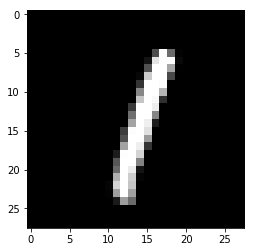

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

pixels = mnist.test.images[5]*255
pixels = np.array(pixels, dtype='uint8')

pixels = pixels.reshape((28, 28))


plt.imshow(pixels, cmap='gray')
plt.show()

# Referência :
[SqueezeNet Paper](https://arxiv.org/abs/1602.07360)